In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import exponential, choice

from langevian_protein import run

In [2]:
residues = ['H', 'P', 'P', 'H', 'H']
coordinates = np.array([
    [0,0,1],
    [0,0,2],
    [0,0,3],
    [0,0,4],
    [0,0,5]
])
friction = 0.05
m = 1
kT = 2
dt = 0.003
k = 20
l = 1
iterations = 10000

In [3]:
potential_record, kinetic_record, energies, temperatures, total_forces, velocities, current_state = run(coordinates, m, residues, k, l, friction, kT, dt, iterations)

-0.1277384991091733 23.22472711444455 23.096988615335377
5.2754341725758245 12.47220579752912 17.747639970104945
0.9363022674465217 16.442871338650804 17.379173606097325
6.321800112430472 13.299402611353553 19.621202723784023
6.814686925387994 11.589527800896478 18.404214726284472
4.558344211885766 11.428500135690182 15.986844347575948
5.163963308925942 20.045028818365022 25.208992127290962
4.046249767187364 18.761798228802576 22.808047995989938
1.094933085131209 14.88804766650391 15.982980751635118
7.448832494670695 6.825610410520779 14.274442905191474


[]

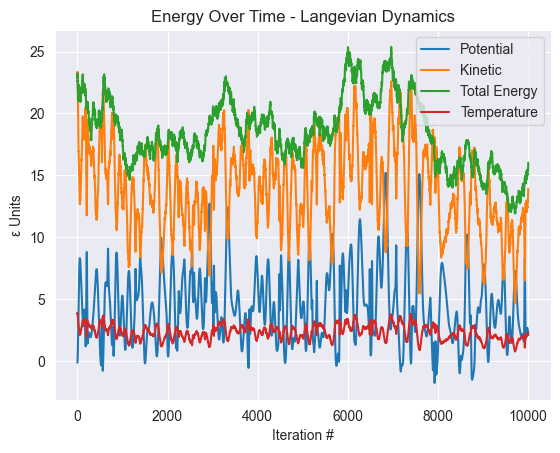

In [4]:
plt.figure()
x = [x for x in range(iterations+1)]
plt.plot(x, potential_record, label="Potential")
plt.plot(x, kinetic_record, label="Kinetic")
plt.plot(x, energies, label="Total Energy")
plt.plot(x, temperatures, label="Temperature")
plt.legend()
plt.xlabel("Iteration #")
plt.ylabel("ε Units")
plt.title("Energy Over Time - Langevian Dynamics")
plt.savefig("../../data/LangevianEnergy.png")
plt.plot()

In [5]:
print("Average Energy over last 1000 time steps: ")
print("Potential: ", np.mean(potential_record[-1000:]))
print("Kinetic: ", np.mean(kinetic_record[-1000:]))

Average Energy over last 1000 time steps: 
Potential:  3.771983421148716
Kinetic:  10.423938435554183


In [6]:
def spatial_gillespie(propensities, initial_state, t_max, rates, stoich, save_freq):
    t = 0 
    ts = [t] 
    s = np.copy(initial_state)
    states = [np.copy(s)]
    iteration = 0
    
    while t < t_max:
        a = propensities(s, rates)               
        tau = exponential(1/np.sum(a))
        mu = choice(np.arange(len(stoich)), p=a/np.sum(a))
        
        s += stoich[mu]
        t += tau
        iteration += 1
        
        if iteration % save_freq == 0:
            states.append(np.copy(s))
            ts.append(t)
    
    ts = np.array(ts)
    states = np.array(states).T
    
    return {'sampled_times': ts, 'states': states}

In [7]:
class Parameters:
    A = 3
    B = 8
    V = 2.0
    
    def __init__(self, k1, k2, k3, k4, x_diffusion, y_diffusion, stoich):
        self.c1 = k1
        self.c1_A = self.c1 * self.A*self.V
        
        self.c2 = 2 * k2/self.V/self.V
        self.c3 = k3/self.V
        self.c3_B = k3 * self.B * self.V
        
        self.c4 = k4
        
        self.x_diffusion = x_diffusion
        self.y_diffusion = y_diffusion
        self.stoich = stoich

In [8]:
s0 = np.array([[20, 4], [20, 4]])
area = 2
D_x = 0.02
D_y = 0.02
t_max = 10

def propensities(s, c):
    return np.array([
        c.c1_A,
        c.c2 * s[0][0] * (s[0][0] - 1)/2 * s[0][1],
        c.c3_B * s[0][0],
        c.c4 * s[0][0],
        c.x_diffusion * s[0][0],
        c.y_diffusion * s[0][1],
        c.c1_A,
        c.c2 * s[1][0] * (s[1][0] - 1)/2 * s[1][1],
        c.c3_B * s[1][0],
        c.c4 * s[1][0],
        c.x_diffusion * s[1][0],
        c.y_diffusion * s[1][1],  # account for both boxes by incrementing the first index
    ])

stoich_matrix = [[[1, 0], [0, 0]], [[1, -1], [0, 0]], [[-1, 1], [0, 0]], [[-1, 0], [0, 0]], [[-1, 0], [0, 0]], [[0, -1], [0, 1]], 
                 [[0, 0], [1, 0]], [[0, 0], [1, -1]], [[0, 0], [-1, 1]], [[0, 0], [-1, 0]], [[0, 0], [-1, 0]], [[0, 1], [0, -1]]
]

parameters = Parameters(k1=1, k2=1, k3=1, k4=1, x_diffusion=D_x/area, y_diffusion=D_y/area,
                        stoich=stoich_matrix)

spatial_trajectory = spatial_gillespie(propensities, s0, t_max, parameters, parameters.stoich, 10)

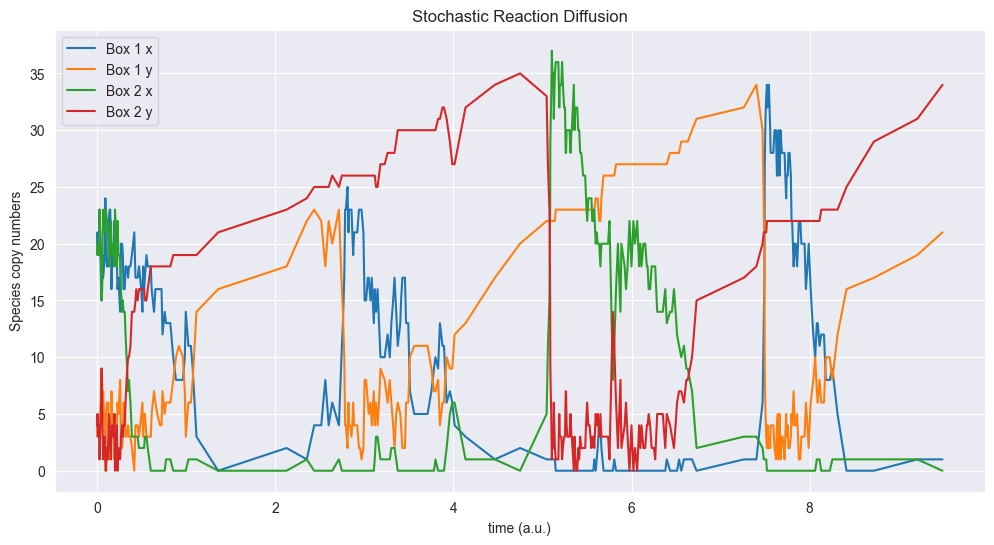

<Figure size 640x480 with 0 Axes>

In [9]:
plt.figure(figsize=[12,6])
plt.plot(spatial_trajectory['sampled_times'], spatial_trajectory['states'][0][0], label="Box 1 x")
plt.plot(spatial_trajectory['sampled_times'], spatial_trajectory['states'][1][0], label="Box 1 y")
plt.plot(spatial_trajectory['sampled_times'], spatial_trajectory['states'][0][1], label="Box 2 x")
plt.plot(spatial_trajectory['sampled_times'], spatial_trajectory['states'][1][1], label="Box 2 y")

plt.xlabel("time (a.u.)")
plt.ylabel("Species copy numbers")
plt.title("Stochastic Reaction Diffusion")
plt.legend()
plt.show()
plt.savefig("../../data/Spatial_gillespie.png")

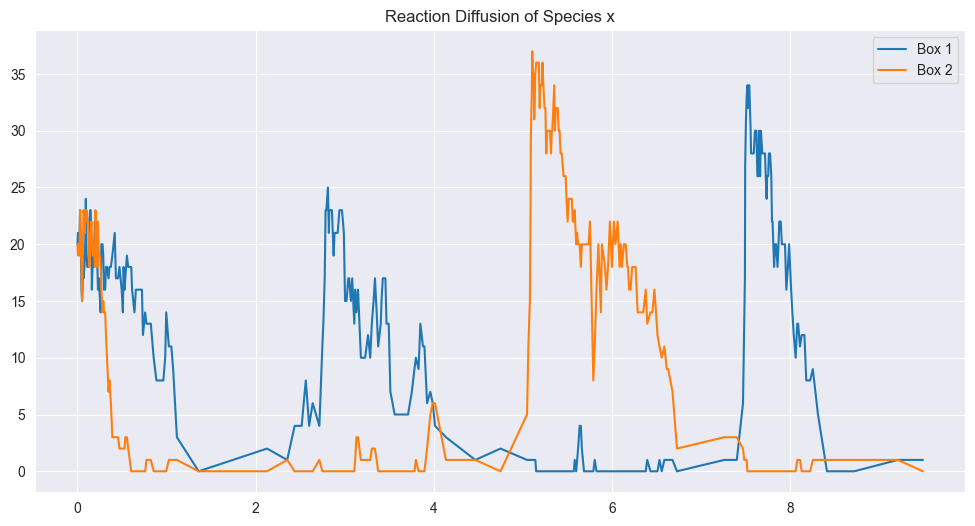

<Figure size 640x480 with 0 Axes>

In [10]:
plt.figure(figsize=[12,6])
plt.plot(spatial_trajectory['sampled_times'], spatial_trajectory['states'][0][0], label="Box 1")
plt.plot(spatial_trajectory['sampled_times'], spatial_trajectory['states'][0][1], label="Box 2")
plt.title("Reaction Diffusion of Species x")
plt.legend()
plt.show()
plt.savefig("../../data/x_compartments.png")

In [11]:
D_x = 0.02*20
D_y = 0.02*20

parameters = Parameters(k1=1, k2=1, k3=1, k4=1, x_diffusion=D_x/area, y_diffusion=D_y/area,
                        stoich=stoich_matrix)

spatial_trajectory = spatial_gillespie(propensities, s0, t_max, parameters, parameters.stoich, 10)

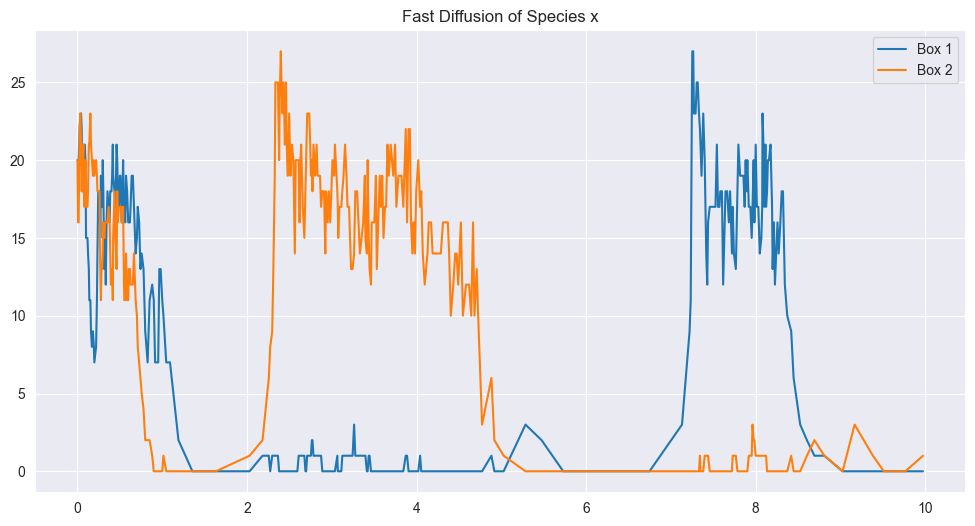

In [12]:
plt.figure(figsize=[12,6])
plt.plot(spatial_trajectory['sampled_times'], spatial_trajectory['states'][0][0], label="Box 1")
plt.plot(spatial_trajectory['sampled_times'], spatial_trajectory['states'][0][1], label="Box 2")
plt.title("Fast Diffusion of Species x")
plt.legend()
plt.show()

The two boxes homogenize faster and therefore there is a large amount of time where nothing happens and the overall copy numbers of species x are low. 